## Assignment 10, Dataset 10
## Student Name: Paria Ighanian, Student ID: 0200155529

### Similar as what we did in the last exercise, we would like to perform link prediction on the same set of edges. Please choose the same edges as those in last exercise as the target of link prediction, and train the model based on the rest of the edges. Different from the methods we used in previous exercise, please use node2vec / DeepWalk embeddings to perform the link prediction. The node2vec algorithm may refer to the implementation in Github: https://github.com/eliorc/node2vec, and DeepWalk may refer to https://github.com/prateekjoshi565/DeepWalk. Please output a report of the prediction accuracy, AUROC, precision and ROC curve.

In [63]:
import networkx as nx
import random
import numpy as np
import pandas as pd
from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, roc_curve
import matplotlib.pyplot as plt



In [64]:
# Load the graph
facebook_G = nx.read_edgelist('Facebook-Ego/3437_3.edges', nodetype=int)

facebook_num_nodes = facebook_G.number_of_nodes()
facebook_num_edges = facebook_G.number_of_edges()
print('Facebook-Ego Netwrok \n----------------------------')
print(f"Number of nodes: {facebook_num_nodes}")
print(f"Number of edges: {facebook_num_edges}")

Facebook-Ego Netwrok 
----------------------------
Number of nodes: 133
Number of edges: 325


In [65]:
random.seed(42)

# Randomly delete 10% of edges
all_edges = list(facebook_G.edges)
num_edges_to_remove = int(0.1 * len(all_edges))
removed_edges = random.sample(all_edges, num_edges_to_remove)

facebook_G.remove_edges_from(removed_edges)

# Generate negative samples 
non_edges = list(nx.non_edges(facebook_G))
negative_samples = random.sample(non_edges, num_edges_to_remove)


#### Step-by-Step Process to Apply DeepWalk ot a graph:

#### 1. Generate Random Walks: The first step is to generate random walks from the nodes of the graph. 

#### 2. Compute Node Embeddings: Once the random walks are generated, we can pass them to the Word2Vec model to learn the embeddings of the nodes. These embeddings will capture the relationships between the nodes based on their positions in the graph.

#### 3. Generate Edge Embeddings: For link prediction, we need embeddings for the edges. One way to do this is by concatenating the embeddings of the two nodes that form each edge.

#### 4. Train Link Prediction Models: After obtaining edge embeddings, we can use them as features to train machine learning models for link prediction.

In [ ]:

def generate_random_walks(graph, num_walks, walk_length):
    walks = []
    nodes = list(graph.nodes())
    
    for _ in range(num_walks):
        random.shuffle(nodes)  # Shuffle nodes for random walks
        for node in nodes:
            walk = [node]  # Initialize the walk with the start node 

            # Perform the random walk
            for _ in range(walk_length - 1):
                cur = walk[-1]
                neighbors = list(graph.neighbors(cur))
                if neighbors:  # If the node has neighbors
                    walk.append(random.choice(neighbors))  # Add a random neighbor
                else:
                    break  # If no neighbors, end the walk early

            walks.append([str(node) for node in walk])  # Convert node ids to strings for Word2Vec

    return walks


In [67]:
# Generate random walks
walks = generate_random_walks(facebook_G, num_walks=10, walk_length=30)

# Train Word2Vec model
model = Word2Vec(walks, vector_size=64, window=10, min_count=1, sg=1, workers=4)

# Function to get edge embeddings
def edge_to_embedding(node_u, node_v):
    return np.concatenate([model.wv[str(node_u)], model.wv[str(node_v)]])

# Generate edge embeddings for training and testing
positive_samples = np.array([edge_to_embedding(u, v) for u, v in removed_edges])
negative_samples = np.array([edge_to_embedding(u, v) for u, v in negative_samples])

X = np.vstack([positive_samples, negative_samples])
y = np.hstack([np.ones(len(positive_samples)), np.zeros(len(negative_samples))])

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


                 Model  Accuracy  AUROC  Precision
0  Logistic Regression      0.60   0.69   0.571429
1        Random Forest      0.70   0.73   0.666667
2                  SVM      0.65   0.69   0.615385


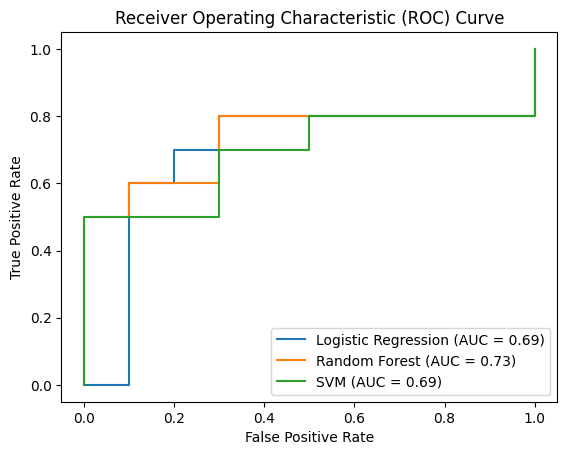

In [68]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

results = []

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred)
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "AUROC": roc_auc,
        "Precision": precision
    })

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Display results
results_df = pd.DataFrame(results)
print(results_df)

# Display ROC Curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()